# Lung Cancer Classification using Computerized Tomography
 Project developed by: **Eduardo Passos** [202205630](https://sigarra.up.pt/fcup/pt/fest_geral.cursos_list?pv_num_unico=202205630), **Pedro Fernandes** [202208347](https://sigarra.up.pt/fcup/pt/fest_geral.cursos_list?pv_num_unico=202208347) and **Rafael Pacheco** [202206258](https://sigarra.up.pt/fcup/pt/fest_geral.cursos_list?pv_num_unico=202206258)


### Index {#index} #############################################
1. [Project Introduction](#intro)
2. [Exploratory Data Analysis](#eda)
3. [Feature Extraction](#ext)
3.1. [Feature Extraction 2D]()
3.2. [Feature Extraction 3D]()
4. [Feature Selection and Dimensionality Reduction](#reduct)
5. [Model Training](#model)
5.1. [Support Vector Machines](#svm)
5.2.
5.3.
5.4. [Stacking]
6. [Ethics](#ethics)

## 1. Project Introduction and Motivation {#intro}  
[Back to Index](#index)  

This project focuses on classifying lung cancer using Computed Tomography (CT) scan data, using the [**LIDC-IDRI** dataset](https://wiki.cancerimagingarchive.net/pages/viewpage.action?pageId=1966254).

As referenced in the assignment, **lung cancer leads global cancer-related mortality rates**, with only 16% of cases diagnosed as local-stage tumors. For these cases, patients have a five-year survival rate exceeding 50%. However, when diagnosed at an advanced stage, the five-year survival rate drops to just 5%. Therefore, **early diagnosis is crucial for improving survival outcomes**, and systems designed to assist with screening can be instrumental in this matter (statistics from the [World Health Organization](https://www.iarc.who.int/featured-news/latest-global-cancer-data-cancer-burden-rises-to-18-1-million-new-cases-and-9-6-million-cancer-deaths-in-2018/) and the [American Cancer Society](https://www.cancer.org/research/cancer-facts-statistics/all-cancer-facts-figures/cancer-facts-figures-2019.html)).

The goal is to **develop a machine learning model capable of accurately identifying lung cancer** (based on the provided medical imaging data) in the early stages of the tumor to prevent disease progression. To support this, we have developed a program that **converts the dataset** (initially in DICOM format) into numpy array files (.npy), while extracting and storing key information in a CSV file.


---

## 2. Exploratory Data Analysis {#eda}
[Back to Index](#index)

The [LIDC-IDRI](https://wiki.cancerimagingarchive.net/pages/viewpage.action?pageId=1966254) dataset **contains the imaging data of the lungs** from over 1000 patients. This dataset is part of a collection of datasets provided by [**The Cancer Imaging Archive**](https://www.cancerimagingarchive.net/browse-collections/) for public research. The medical imaging data is provided in [**DICOM**](https://en.wikipedia.org/wiki/DICOM) (.dcm), and contains both image data, and associated metadata. It also contains the annotations of the medical professionals regarding the subject. 

The nodule annotations in the dataset **reflect the radiologist's evaluation** and include key information such as nodule size and malignancy rating (on a scale from 1-5). However, the **malignancy classification may vary based on each radiologist's judgment** and reasoning. What this means is that it introduces a level of subjectivity, making the classification potentially ambiguous and not always straightforward.

The dataset contains noise, missing data, and file corruption. Some patients have incomplete annotations or no annotations at all, which complicates the training process since not all scans contain the necessary labels for nodule classification. 

Regarding the distribution of the nodule count, we can assess it using the available file in the link provided, downloaded in the folder and imported below.
(The file was cleaned and converted to csv)


In [1]:
import pandas as pd

eda_df = pd.read_csv("lidc-idri-nodule-counts-6-23-2015.csv")
eda_df.head()

,TCIA Patent ID,Total Number of Nodules*,Number of Nodules >=3mm**,Number of Nodules <3mm***
0,LIDC-IDRI-0001,4,1,3
1,LIDC-IDRI-0002,12,1,11
2,LIDC-IDRI-0003,4,4,0
3,LIDC-IDRI-0004,4,1,3
4,LIDC-IDRI-0005,9,3,6


**This is the description of the columns above**, removed from the original excel.

*total number of lesions that received either a "nodule < 3mm" mark or a "nodule >= 3mm" mark from at least one of the four LIDC radiologists

**total number of lesions that received a "nodule >= 3mm" mark from at least one of the four LIDC radiologists (regardless of how the other radiologists marked the lesion)

***total number of lesions that received a "nodule < 3mm" mark from at least one of the four LIDC radiologists (with no radiologist assigning the lesion a "nodule >= 3mm" mark)

Our analysis will be based on the nodules with a size equal or greater than 3mm, meaning that the important part to analyse.

Minimum nodules >= 3mm: 0
Maximum nodules >= 3mm: 23
Mean nodules >= 3mm: 2.6218074656188604
Median nodules >= 3mm: 2.0
Standard deviation: 2.6654488137691392


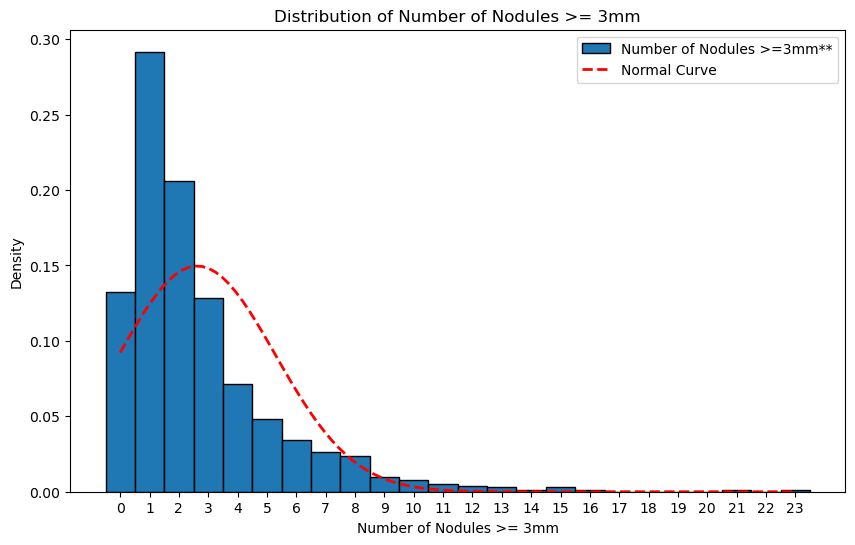

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Assuming eda_df is already defined and contains the relevant data
nodules_gte_3mm = eda_df["Number of Nodules >=3mm**"]

# Calculate statistics
min_nodules = nodules_gte_3mm.min()
max_nodules = nodules_gte_3mm.max()
mean_nodules = nodules_gte_3mm.mean()
median_nodules = nodules_gte_3mm.median()
std_dev_nodules = nodules_gte_3mm.std()

print("Distribution Summary of the Nodules: ")
print(f"Minimum nodules >= 3mm: {min_nodules}")
print(f"Maximum nodules >= 3mm: {max_nodules}")
print(f"Mean nodules >= 3mm: {mean_nodules}")
print(f"Median nodules >= 3mm: {median_nodules}")
print(f"Standard deviation: {std_dev_nodules}")

# Setting up bins for the histogram
bin_edges = np.arange(min_nodules - 0.5, max_nodules + 1.5, 1)

# Plotting histogram with pandas (density=True for normalization)
ax = nodules_gte_3mm.plot(kind='hist', bins=bin_edges, edgecolor='black', figsize=(10, 6), density=True)
ax.set_title("Distribution of Number of Nodules >= 3mm")
ax.set_xlabel("Number of Nodules >= 3mm")
ax.set_ylabel("Density")  # Changed to Density

# Create a range of x values for the normal curve
x_values = np.linspace(min_nodules, max_nodules, 100)

# Calculate the normal distribution values
normal_curve = norm.pdf(x_values, mean_nodules, std_dev_nodules)

# Plot the normal curve
ax.plot(x_values, normal_curve, color='red', linestyle='--', linewidth=2, label='Normal Curve')

# Set x-ticks
ax.set_xticks(np.arange(min_nodules, max_nodules + 1))

# Show legend
ax.legend()

# Display the plot
plt.show()


We can evaluate if the nodule count follow a normal distribution, using a **Lilliefors Test**.
The reason to use that test specifically, is that it is meant to evaluate the normality of the population, however, contrary to the Kolmogorov-Smirnov Test, we do not know the whole population parameters, meaning we estimate the mean and deviation based on the sample, in this case, this dataset.

In [13]:
from statsmodels.stats.diagnostic import lilliefors

stat, p_value = lilliefors(nodules_gte_3mm)

# Print results
print(f"Lilliefors Test Statistic: {stat}")
print(f"P-Value: {p_value}")

# Determine if we reject the null hypothesis
alpha = 0.05
if p_value < alpha:
    print("Decision: Reject the null hypothesis: the data is likely not normally distributed.")
else:
    print("Decision: Fail to reject the null hypothesis: no evidence that the data is not normally distributed.")


Lilliefors Test Statistic: 0.22287802078830904
P-Value: 0.0009999999999998899
Decision: Reject the null hypothesis: the data is likely not normally distributed.


There is no evidence, contrary to what we believed, that the nodule count distribution follow a normal distribution.

## 3. Feature Extraction {#ext}
[Back to Index](#index)

To train the models, we considered extracting features both in 2D, by layers that contain the nodules, and in 3D, extracted using a NN, and other radiomic features.

Both processes will be described below, however, although working properly, we were not able to figure out how to classify the slices of the 2D extraction properly. The reason for so, is that some slices of the same nodule might be malign and some not, and since we don't have the individual slice classification/opinion by the doctors, we ended up not being able to classify the slices as we aimed initially.

### 3.1. Feature Extraction 2D
[Back to Index](#index)

This chapter explains the code behind the `feature_extraction_2D.py` script, created to find the nodule slices obtained using the `pylidc` library to extract and store radiomic and image features related to lung nodules. The processed data includes nodule images, masks, metadata, and radiomic features, all saved for further machine learning tasks.

#### 1. Key Libraries

- **pylidc**: Used to interact with the LIDC-IDRI dataset, including extracting scan and nodule information.
- **SimpleITK**: Performs medical image processing tasks, such as converting images to and from arrays for manipulation.
- **radiomics**: Extracts quantitative radiomic features from 3D medical images, like shape, texture, and intensity.
- **scipy/ndimage**: Used for data augmentation via image rotation.
- **pandas**: Organizes metadata in dataframes and saves them to CSV.

#### 2. Configuration Settings
[Back to Index](#index)

The script reads parameters from a configuration file (`lung.conf`). These settings include:

1. **Directories**:
   - `LIDC_DICOM_PATH`: Location of the DICOM files.
   - `MASK_PATH`: Where masks are saved.
   - `IMAGE_PATH`: Where cropped and processed nodule images are stored.
   - `META_PATH`: Location for saving metadata files.

2. **Hyperparameters**:
   - **mask_threshold**: Minimum pixel count for a mask to be considered valid.
   - **confidence_level**: Used for consensus mask generation from annotations.
   - **padding_size**: Padding around the nodule region during cropping.

#### 3. Class: `MakeDataSet`

This class handles the processing of each scan, extracting nodule-related data, generating masks, calculating features, and saving all information for later use.

Before processing each scan, data quality is assessed based on:
- The existence of slice values (`slice_zvals`) and DICOM images.
- Consistency in slice thickness.
- The number of slices and image availability.

The malignancy of each nodule is calculated using the **median of annotations** provided by radiologists. Malignancy scores determine if a nodule is labeled as **cancerous** or **non-cancerous**. CT scans are normalized based on **Hounsfield Units (HU)** to focus on regions of interest. Values are clipped and rescaled to fit within a range of 0 to 1.

The class uses the **Radiomics Feature Extractor** to compute a variety of 3D features from the normalized images and their corresponding masks. These features include shape, intensity, and texture metrics.

#### 4. Nodule Processing

For each patient, the script:
1. Loads the full CT scan and normalizes it.
2. Iterates through each detected nodule, performing the following tasks:
   - Extracts a **consensus mask** based on the annotations.
   - **Crops** the nodule area and mask.
   - Saves the cropped image and mask to disk.
   - **Augments** the data by rotating the images and masks in various angles around different axes.
   - **Extracts radiomic features** from both the original and augmented images.
   - **Stores metadata** about each nodule, including malignancy score and radiomic features.

#### 5. Data Augmentation

For each nodule, the script applies rotations to the cropped image and mask in the x, y, and z planes. These augmented images are saved with distinct file names, increasing the variety of data for training machine learning models.

#### 6. Metadata and Output

All extracted features and relevant metadata are saved to a **CSV file**. This metadata includes:

- Patient ID
- Nodule number
- Original and mask image file names
- Malignancy score
- Radiomic features

The CSV is finalized at the end of the processing, and can later be used to train models based on them.

#### 7. Main Function

The script processes a specified number of LIDC-IDRI scans (up to 10 in the default configuration). For each scan, it initializes the `MakeDataSet` class and calls the `process_scan()` method to handle all data extraction, augmentation, and saving tasks.



---
### 3.2. Feature Extraction 3D 
[Back to Index](#index)

This chapter explains the code behind the `feature_extraction_3D.py` script, designed to extract features from the dataset. This script uses a combination of libraries for medical image processing, radiomic feature extraction, and deep learning-based feature extraction using a [CNN (ResNet-18 model)](https://medium.com/analytics-vidhya/resnet-understand-and-implement-from-scratch-d0eb9725e0db). Below is an in-depth explanation of the "routines" that constitute the process.


#### 1) Key Libraries

- **pylidc**: For the interaction with the LIDC-IDRI dataset.
- **SimpleITK**: For medical image processing tasks.
- **radiomics**: Provides various techniques to extract quantitative radiomic features from 3D medical imaging, like shape, texture, and intensity-based features.
- **torch and monai**: Used to train the neural network for feature extraction. Specifically, `monai.networks.nets.ResNet18`, which provides a pre-trained ResNet-18 CNN model designed for medical imaging tasks.

#### 2) Command-Line Argument Parsing: 

The `parse_arguments()` function uses Python's `argparse` library to parse command-line arguments, allowing for flexible and customizable script behavior. The **arguments defined** are the following:

1. **`--output_dir`**: Specify the folder to save the extracted feature CSV files.
   
2. **`--log_file`**: Path to the file where the script will write all its logs and messages. 

3. **`--csv_file`** (Optional): Choose whether to save all features in a single CSV file or in 2, this is where you set the path. (individual CSVs are saved by default)

4. **`--scan_limit`**: Control how many scans the script processes. If 0 or a negative number, it will process all available scans.

5. **`--consensus_level`**: This sets the confidence level (between 0 and 1) for generating a consensus mask from multiple radiologist annotations.

6. **`--num_workers`**: Number of worker threads for parallel processing. 

7. **`--cnn_feature_dim`**: Defines the size of the CNN feature vector to extract, with a default set at 128 dimensions.

8. **`--model_path`**: Path to a pre-trained CNN model. If none is provided, the script will use a ResNet-18 model from the MONAI library as the fallback.

Parsed arguments can be easily accessed throughout the script.


#### 3) Resampling and HU Normalization

To ensure reliability and standardization across scans, the 3D CT scans are resampled to a fixed voxel spacing using **trilinear interpolation**. This ensures that the scans from different machines or resolutions are brought to a consistent format.

Additionally, Hounsfield Units (HU), which represent the density values in CT images, are normalized. This involves two main functions:

- **`clamp_hounsfield_units()`**: Clamps HU values within a specific range (e.g., -1000 to 400) to focus on the regions of interest like lung tissue (excluding irrelevant areas like air or bones).
- **`normalize_intensity()`**: Further scales the intensity values for consistent input into the neural network model.


#### 4) Bounding Box Calculation: 

After preprocessing, the `get_bounding_box()` determines the **bounding box** for each nodule in the scan:

- The **binary mask** representing the nodule is processed to find the smallest box that contains all `True` (or 1) values, which represent the nodule region.
- This is crucial for reducing the amount of data being processed, focusing only on the nodule area instead of the entire scan.


#### 5) Nodule Extraction and Resizing

Once the bounding box is determined, the nodule is extracted from the original 3D scan. The extracted nodule is then resized to a consistent shape and size, making it ready for feature extraction. This is especially important for the CNN, which expects inputs of fixed dimensions.


#### 6) Malignancy Evaluation

Each nodule in the LIDC-IDRI dataset is annotated by multiple radiologists, and each provides a score for malignancy (among other characteristics). The **median score** of malignancy is used as a target label for training the model. This helps in creating a more robust and reliable training dataset by minimizing bias from individual radiologists' evaluations.


#### 7) CNN-Based Feature Extraction: ResNet-18

For deep learning-based feature extraction, a **ResNet-18 CNN model** is applied to each extracted nodule. ResNet-18 is a well-known architecture that introduces residual connections, enabling deeper networks to be trained efficiently.

- The script uses a **pre-trained ResNet-18 model** (either provided via `--model_path` or by default from MONAI).
- The model extracts **CNN features** of a predefined size (e.g., 128-dimensional), which are saved as part of the final feature set.

The architecture of this convolutional NN is the following [image](https://www.researchgate.net/figure/Original-ResNet-18-Architecture_fig1_336642248): 
![](ResNet-18-Architecture.png)

#### 8) Radiomic Feature Extraction

In addition to CNN-based features, the script also uses the **radiomics library** to extract traditional radiomic features from the nodules. These features include:

- **Shape features**: Describing the geometric properties of the nodule (e.g., volume, elongation, flatness).
- **Texture features**: Quantifying the patterns and variations in pixel intensity within the nodule.
- **Intensity-based features**: Capturing the intensity distribution in the nodule region.


#### 9) Feature Aggregation and Output

Once both CNN and radiomic features are extracted, they are **aggregated into a final CSV file**. Each row in the CSV file represents a nodule, meaning each nodule is evaluated independently, and helps on the case of a patient having different nodules.

This CSV file serves as the input for subsequent machine learning tasks.

The script is designed to save separate CSV files for each nodule by default. However, an option is provided to save a single CSV file containing all features via the `--csv_file` argument.

---

## 4. Feature Selection and Dimensionality Reduction {#reduct}
[Back to Index](#index)

There are 3 different "types of data" as a result of the scripts made for processing:
- `lidc_meta_info_2d.csv`: contains the features for each slice individually, meaning the model will be trained in single slices, since the same nodule can have malignant slices and benign slices simultaneously;
- `lidc_meta_info_3d.csv`: contains the 3D features extracted using the script mentioned in 3.2.
- `lidc_cnn_features.csv`: contains the ResNet18 features also described above.

To develop the models, the `lidc_meta_info_3d.csv` and `lidc_cnn_features.csv` can be merged using the `merge_csvs.py`, if they are created individually, when defining the script behaviour on the `feature_extraction_3d.py`.

The dataset is going to cleaned and the process explained in the `cleanup_2d.ipynb` and `cleanup_3d.ipynb`. To summarise the process in both scripts, we will:

- Evaluate the missing values and outliers.
- Delete repeated values and duplicated columns.
- **Assess column correlation** with the target variable.
- Perform a **Recursive Feature Extraction** to select the best features, so that the model training is easier to perform.
- Assess the final dataset quality, using classification report and different metrics.

After the script's execution, we can use the `lidc_clean_rfe50.csv` file, result of the 3D extraction, that will be used to perform the model training.

From now onwards, we will only talk about the 3d extraction result, for the reasons stated before.

---

## 5. Model Development and Training

To train the models, we opted for a **stacking** approach. To select the models for stacking, we developed a Jupyter notebook located in the `3_model_development` folder, where we explore different methods of overcoming obstacles in the problem and test a variety of models.

**Stacking is an ensemble technique** in AI where multiple models are combined to improve predictive performance. In stacking, different models (often of various types) are trained on the same dataset, and their predictions are then used as inputs for a “meta-model” that learns to make the final prediction. **This approach leverages the strengths of each individual model**, helping to reduce errors and increase accuracy by compensating for their individual weaknesses.

We evaluated the model performance on another independent dataset, the [SPIE-AAPM-NCI](https://www.cancerimagingarchive.net/collection/spie-aapm-lung-ct-challenge/) dataset, which we will refer to as **LungX dataset**, since this was part of a challenge on image analysis methods, called LungX.

The features extracted for this new dataset were the result of the script `feature_extraction_LUNGx.py`, which is an adaptation of the 'feature_extraction_3d.py'.

First of all, we imported the libraries and the dataset `lidc_rfe_50.csv`, generated on the chapter 4.

In [ ]:
# import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import warnings
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import StackingClassifier


lidc_df = pd.read_csv('./2_csv_manipulation/lidc_rfe50.csv')
lidc_df.head()

,is_cancer,resnet3d_feature_33,resnet3d_feature_41,resnet3d_feature_52,resnet3d_feature_63,resnet3d_feature_64,resnet3d_feature_66,resnet3d_feature_67,resnet3d_feature_68,resnet3d_feature_72,...,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_RobustMeanAbsoluteDeviation,original_firstorder_Skewness,original_firstorder_Variance,original_gldm_DependenceNonUniformityNormalized,original_glrlm_GrayLevelNonUniformity,original_glrlm_LongRunEmphasis,original_glrlm_RunLengthNonUniformity,original_glrlm_ShortRunEmphasis
0,2,0.339816,0.562524,0.442979,0.730204,0.333658,0.491633,0.398934,0.413691,0.399483,...,0.364344,0.011082,0.001734,0.648394,0.005157,0.210980,0.878810,0.157930,0.324954,0.496851
1,2,0.526288,0.736178,0.486639,0.796184,0.340574,0.547593,0.475688,0.532664,0.690380,...,0.161537,0.034874,0.000000,0.359984,0.000511,0.465737,0.890961,0.364065,0.240920,0.253756
2,0,0.616598,0.428909,0.104794,0.619367,0.502572,0.125043,0.291206,0.484636,0.376556,...,0.224852,0.000876,0.000000,0.610007,0.002463,0.448261,0.874003,0.314858,0.249673,0.428741
3,2,0.395332,0.431717,0.251262,0.735690,0.667631,0.282189,0.237252,0.245101,0.460938,...,0.368496,0.004530,0.004242,0.659629,0.006736,0.313686,0.804823,0.218568,0.269539,0.537671
4,1,0.432535,0.491978,0.446434,0.571172,0.847354,0.442363,0.294933,0.210586,0.340075,...,0.570872,0.018355,0.163190,0.800094,0.029328,0.247511,0.736251,0.118588,0.323211,0.432529


We also need to import the lungX dataset, however if we perform the same RFE, we are **not guaranteed to get the same columns**, therefore we need to select the columns manually, so that we can train on one and test on the other.

In [42]:
lungx_df = pd.read_csv('./2_csv_manipulation/lungX_merged.csv')

lidc_rfe_features = lidc_df.columns
lungx_df = lungx_df[lidc_rfe_features]

lungx_df.head()

,is_cancer,resnet3d_feature_33,resnet3d_feature_41,resnet3d_feature_52,resnet3d_feature_63,resnet3d_feature_64,resnet3d_feature_66,resnet3d_feature_67,resnet3d_feature_68,resnet3d_feature_72,...,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_RobustMeanAbsoluteDeviation,original_firstorder_Skewness,original_firstorder_Variance,original_gldm_DependenceNonUniformityNormalized,original_glrlm_GrayLevelNonUniformity,original_glrlm_LongRunEmphasis,original_glrlm_RunLengthNonUniformity,original_glrlm_ShortRunEmphasis
0,0,0.758687,0.878355,1.471844,3.723126,0.312700,0.228197,3.192970,2.839735,1.729669,...,-0.605919,-1.329309,0.215211,1.541279,0.313766,0.074784,562.413452,29.410648,152.483867,0.349953
1,0,0.788619,0.261186,0.982488,3.209772,0.374429,0.170063,3.442891,2.738006,1.407319,...,-0.040460,-1.289957,0.458105,0.304619,0.338828,0.047514,804.972961,11.523931,403.749178,0.488998
2,0,0.897960,0.104052,0.986428,2.714004,0.095972,0.000000,4.120328,3.219524,1.098788,...,1.002698,1.002698,0.000000,0.000000,0.000000,0.381863,446.846154,111.857853,46.773800,0.053022
3,1,0.842166,0.833179,1.459497,3.307788,0.403149,0.278683,3.162763,2.811933,1.671032,...,-0.627479,-1.264208,0.149408,1.887496,0.143211,0.145731,470.940344,51.177122,101.075737,0.332902
4,1,0.877683,0.132523,0.863842,2.927402,0.191573,0.042281,3.667842,3.073891,1.022333,...,1.181057,-1.031140,0.193052,-1.745681,0.194022,0.220702,438.960009,59.064984,92.763792,0.326298


Now we are set to create the models.

In [43]:
# 1. Load the Combined and Cleaned Dataset
df = pd.read_csv(r'2_csv_manipulation/lidc_rfe50.csv')

# Removes ambiguous option
df_rem = df.copy()
before = df_rem.shape[0] # n_linhas antes

mask = df_rem['is_cancer'] == 1
df_rem = df_rem[~mask]
after = df_rem.shape[0] # n_linhas depois

df_rem['is_cancer'] = df_rem['is_cancer'].replace(2, 1)
print(f"Row size changed from {before} to {after} (lost {before-after} rows).")

Row size changed from 2626 to 1238 (lost 1388 rows).


In [44]:
data = df_rem.copy()

# 2. Prepare X and y
# Assuming 'is_cancer' is your target variable
X = data.drop(['is_cancer'], axis=1)
y = data['is_cancer']

# Map target to integer
if y.dtype == 'object' or y.dtype == 'str':
    y = y.map({'False': 0, 'Ambiguous': 1, 'True': 2})

In [45]:
# 3. Standardize the Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [46]:
# 4. Split the Data into Training and Test Sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# 5. Handle Class Imbalance (if necessary)
# Check class distribution
print("Class distribution in the training set:")
print(y_train.value_counts())

Class distribution in the training set:
is_cancer
0    690
1    300
Name: count, dtype: int64


In [47]:
# Apply SMOTE to balance the classes
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("Class distribution in the training set after applying SMOTE:")
print(y_train_res.value_counts())

Class distribution in the training set after applying SMOTE:
is_cancer
1    690
0    690
Name: count, dtype: int64


In [48]:
best_model_xgb = XGBClassifier(eval_metric='mlogloss')
best_forest = RandomForestClassifier(class_weight='balanced')
lda_model = LogisticRegression(max_iter=900)

# Define the base models (XGBoost and GBDT)
base_models = [
    ('forest', best_forest),
    #('xgb', best_model_xgb),  # Best XGBoost model from GridSearch
    #('lda', lda_model)
]

# Logistic Regression is commonly used for stacking
meta_model = LogisticRegression(max_iter=900)

# Define the Stacking Classifier
stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,  # Perform 5-fold cross-validation within stacking
    n_jobs=-1
)

# Train the Stacking Model
stacking_model.fit(X_train_res, y_train_res)


StackingClassifier(cv=5,
                   estimators=[('forest',
                                RandomForestClassifier(class_weight='balanced'))],
                   final_estimator=LogisticRegression(max_iter=900), n_jobs=-1)

Stacking Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       173
           1       0.80      0.84      0.82        75

    accuracy                           0.89       248
   macro avg       0.86      0.87      0.87       248
weighted avg       0.89      0.89      0.89       248



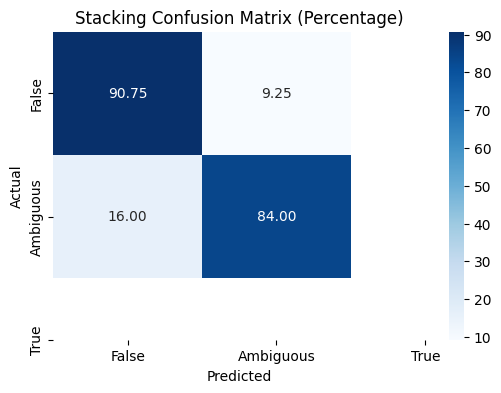

In [51]:
# Evaluate the Stacking Model
y_pred_stack = stacking_model.predict(X_test)
y_prob_stack = stacking_model.predict_proba(X_test)

# Stacking Classification Report
print("Stacking Classification Report:")
print(classification_report(y_test, y_pred_stack))

# Stacking Confusion Matrix with Percentages
cm_stack = confusion_matrix(y_test, y_pred_stack)
cm_stack_percentage = cm_stack / cm_stack.sum(axis=1)[:, np.newaxis] * 100  # Normalize by row

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm_stack_percentage,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    xticklabels=['False', 'Ambiguous', 'True'],
    yticklabels=['False', 'Ambiguous', 'True'],
)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Stacking Confusion Matrix (Percentage)')
plt.show()


# Stacking ROC-AUC Score
#roc_auc_stack = roc_auc_score(y_test, y_prob_stack, multi_class='ovr')
#print("Stacking ROC-AUC Score:", roc_auc_stack)

---

# 6. Ethics {#ethics}  
[Back to Index](#index)  

Given that our project is focused on Medicine, we believe it may bring benefits in terms of diagnostic accuracy, improved decision-making, and personalized treatment.

Throughout this chapter, we will discuss topics such as the traceability of participants in the data collection campaign, as well as the explainability and transparency of the final AI system.

After assigning tasks to the group members, we began working on the LIDC-IDRI dataset, performing various types of analysis and data cleaning with the aim of improving the quality of information provided to classification models.

Although we were not involved in the stage with direct patient interaction, we chose to reflect on and plan how we would approach the most ethically sensitive aspects if we were responsible for the entire public data collection process.

We would take into account the potential involvement of personal data in medical contexts, applying strict principles of data minimization and anonymization to ensure that only essential information is collected, thus safeguarding participant privacy.

Following this process, we would utilize de-identification techniques and data protection policies to ensure confidentiality and data security, as well as a clear procedure for data deletion (right to be forgotten), so that patients would retain control over their data.

We would also consider potential biases in training data to ensure fairness. Additionally, we would provide intuitive instructions for the reproducibility of the results obtained.

### Disclaimer

This tool is intended to **assist qualified medical professionals in the classification of tumors** and should **not be used as a sole** diagnostic tool. While every effort has been made to ensure the accuracy of the model, there is an inherent risk of misclassification, including potential false positives or false negatives. **This system is designed as a decision-support aid and must be used in conjunction with clinical expertise and additional diagnostic procedures.** The developers do not assume liability for any adverse outcomes resulting from the model’s recommendations, and it is the responsibility of the medical practitioner to verify results and make the final diagnostic decision.